In [18]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pycmap
import seaborn as sns
from tlviz.factor_tools import factor_match_score
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [84]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# div_hexes = ['#7222D3', neutral_color, '#FF780A']
# div_cmap = get_continuous_cmap(div_hexes)


In [3]:
# helper functions

def unique_bins(array, n_bins, bounds=None, reverse=False):
    '''This is a function that maps an array of continuous values with potential duplicates to 
    a set of bins in such a way that each of the original continuous values is mapped to a unique bin, and the
    distribution of binned values approximates the distribution of continuous values as closely as possible.
    
    My quick and dirty approach to this problem sorts the input array into the appropriate number of bins. Then,
    starting in the middle and alternating outward left and right, the algorithm checks to see if each bin has 
    more than one resident. If so, it will again alternate outward left and right from that position and allocate
    the extra residents to the nearest free bins.
    
    Parameters
    ----------
    array : np.array
        Sorted array of values to be placed into bins.
    n_bins : int
        Number of bins to use.
    bounds : (float, float)
        Upper and lower bounds to use for bin-mapping.
    reverse : bool
        Optional flag to reverse the index ordering of the output.
    
        
    Returns
    -------
    index : np.array
        Indices indicating mapping of input values to bins, where index[i] indicates the index of the bin 
        mapping of input value array[i] (assuming input array is sorted).
    '''
    # check number of bins
    if not n_bins >= len(array):
        raise ValueError('The number of bins must be >= len(array).')
    # add bounds if supplied
    if bounds is not None:
        array = np.concatenate((array, bounds))
    # make histogram
    counts, _ = np.histogram(array, bins=n_bins)
    # remove bounds if added
    if bounds is not None:
        counts[0] -= 1
        counts[-1] -= 1
    # start from the middle
    i = int(n_bins/2)
    for j in range(n_bins):
        # alternate left and right
        if j % 2:
            i -= j
        else:
            i += j
        # resolve collisions
        if counts[i] > 1:
            # set new counter for exploring nearby positions
            k = i
            for l in range(2*n_bins):
                # alternate left and right
                if l % 2:
                    k -= l
                else:
                    k += l
                # check if we're still in range
                if 0 <= k < n_bins:
                    # check for an empty spot
                    if counts[k] == 0:
                        counts[k] = 1
                        counts[i] -= 1
                        # check if all collisions have been resolved yet
                        if counts[i] == 1:
                            break
    # select indices of non-zero values
    index = np.where(counts == 1)[0]
    # reverse if requested
    if reverse:
        index = (n_bins - 1) - index
    return index


# import data

In [4]:
# read in aligned model datasets

datapath = Path('../../data/5-models/')

pro_ds = xr.open_dataset(datapath / 'pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / 'syn-aligned-models.nc')

pro_ds

<xarray.Dataset>
Dimensions:           (bootstrap: 100, replicate: 3, component: 20,
                       ortholog: 5084, clade: 3, samplename: 76)
Coordinates:
  * bootstrap         (bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * replicate         (replicate) object 'A' 'B' 'C'
  * component         (component) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20
  * ortholog          (ortholog) int64 60000001 60000002 ... 60040287 60040292
  * clade             (clade) object 'HLI' 'HLII' 'LLI'
  * samplename        (samplename) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.N...
Data variables:
    componentweights  (bootstrap, replicate, component) float64 ...
    geneweights       (bootstrap, replicate, component, ortholog) float64 ...
    taxonweights      (bootstrap, replicate, component, clade) float64 ...
    sampleweights     (bootstrap, replicate, component, samplename) float64 ...
    sample            (bootstrap, replicate, samplename) object ...

In [5]:
# read in metadata

sample_df = pd.read_csv('../../data/metadata/archive/sample_metadata_merged.csv')

sample_df


,samplename,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [7]:
# import data from cmap

api = pycmap.API(token='55bd80f9-8d5d-4c8f-8917-f5b0e924ed45')
api.search_catalog('iron John gradients')


In [31]:
# import all iron data from G1, G2, G3

fe_df = pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_Diss_Trace_Metal_Profile'), 
    api.get_dataset('tblMGL1704_Gradients2_Diss_Trace_Metal_Profile'), 
    api.get_dataset('tblMGL1704_Gradients2_Diss_Trace_Metal_Surface'), 
    api.get_dataset('tblKM1906_Gradients3_Diss_Trace_Metal_Profile')
]).reset_index(drop=True)
fe_df['year'] = pd.to_datetime(fe_df['time']).dt.year

fe_df


,time,lat,lon,depth,Cd_dissolved,Pb_dissolved,Fe_dissolved,Ni_dissolved,Cu_dissolved,Zn_dissolved,Mn_dissolved,Co_dissolved,year
0,2016-04-20T08:00:00,23.500000,-158.00000,15.0,0.000000,42.387016,0.133943,2.112766,0.520765,0.406267,0.978415,2.886313,2016
1,2016-04-20T08:00:00,23.500000,-158.00000,45.0,0.000000,40.404233,0.112573,2.144578,0.487953,0.041618,0.956071,1.607434,2016
2,2016-04-20T08:00:00,23.500000,-158.00000,130.0,2.619439,38.345184,0.148592,2.123560,0.530634,0.376382,0.616861,5.833796,2016
3,2016-04-20T08:00:00,23.500000,-158.00000,150.0,9.897086,40.218990,0.397744,2.192099,0.562793,0.346099,0.508902,5.351234,2016
4,2016-04-20T08:00:00,23.500000,-158.00000,200.0,56.298971,70.479227,0.402671,2.449607,0.689346,0.183127,0.334094,11.862347,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2019-04-24T00:00:00,42.333888,-158.00595,75.0,0.156920,0.051880,0.423880,3.489863,1.107804,0.624393,0.859485,0.016049,2019
357,2019-04-24T00:00:00,42.333888,-158.00595,100.0,0.208297,0.069508,1.140576,3.679030,1.401452,2.271989,0.795996,0.021737,2019
358,2019-04-24T00:00:00,42.333888,-158.00595,200.0,0.436411,0.078711,1.454341,4.160885,1.469514,3.321238,0.484288,0.027267,2019
359,2019-04-24T00:00:00,42.333888,-158.00595,300.0,0.581454,0.082272,1.584558,4.917585,1.768565,4.342330,0.446200,0.029886,2019


In [144]:
# import nitrogen data

# dissolved nitrate+nitrite (Karl lab)
n_diss_df =  pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_Nutrients'), 
    api.get_dataset('tblMGL1704_Gradients2_Nutrients'), 
    api.get_dataset('tblKM1906_Gradients3_Organic_Inorganic_Nutrients').rename(columns={'NO3_plus_NO2': 'NO3_NO2'})
]).reset_index(drop=True)
n_diss_df['year'] = pd.to_datetime(n_diss_df['time']).dt.year

# particulate nitrogen (White lab)
n_part_df =  pd.concat([
    api.get_dataset('tblKOK1606_Gradients1_PPPCPN_UW'), 
    api.get_dataset('tblMGL1704_Gradients2_PPPCPN_UW'), 
    api.get_dataset('tblKM1906_Gradients3_PCPN_UW')
]).reset_index(drop=True)
n_part_df['year'] = pd.to_datetime(n_part_df['time']).dt.year

n_part_df


,time,lat,lon,depth,sst,sss,pp,less_than_pt7_micron_P,pc,less_than_pt7_micron_C,pn,less_than_pt7_micron_N,year
0,2016-04-19T21:50:24,21.349670,-158.273311,4,25.929151,34.691601,9.105438,NaN,1.284700,0.244473,0.169196,0.044593,2016
1,2016-04-19T23:16:48,21.375818,-158.285514,4,26.169823,34.701296,NaN,NaN,1.439305,NaN,0.199886,NaN,2016
2,2016-04-20T00:43:12,21.539773,-158.326706,4,25.734921,34.680177,7.478179,NaN,1.863896,NaN,0.263056,NaN,2016
3,2016-04-20T01:55:12,21.736119,-158.314162,4,25.425718,34.754452,NaN,NaN,1.956674,NaN,0.272461,NaN,2016
4,2016-04-20T03:21:36,21.925783,-158.291590,4,24.852175,34.805635,12.252132,NaN,1.865808,NaN,0.267129,NaN,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,2019-04-24T17:32:03,41.169507,-158.001271,6,10.059222,33.629599,NaN,NaN,9.170116,NaN,1.493648,NaN,2019
481,2019-04-24T19:32:00,41.558662,-157.999909,6,9.731587,33.583564,NaN,NaN,6.522379,NaN,1.033731,NaN,2019
482,2019-04-24T21:32:58,41.950718,-157.999928,6,9.370388,33.562780,NaN,NaN,6.423381,NaN,1.084268,NaN,2019
483,2019-04-24T23:33:04,42.298812,-158.000246,6,9.225866,33.936953,NaN,NaN,7.670676,NaN,1.334386,NaN,2019


# plot data

In [24]:
# pull out clusters hypothesized to relate to iron limitation

pro8_df = pro_ds.sel(component=8).sampleweights.to_series().reset_index()
pro8_df['genus'] = 'Prochlorococcus'
syn5_df = syn_ds.sel(component=5).sampleweights.to_series().reset_index()
syn5_df['genus'] = 'Synechococcus'

fe_cluster_df = pd.concat([pro8_df, syn5_df]).reset_index(drop=True)
fe_cluster_df = pd.merge(fe_cluster_df, sample_df, on='samplename', how='left')

fe_cluster_df


,bootstrap,replicate,samplename,sampleweights,genus,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,0,A,G1.SURF.NS.S02C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,0,A,G1.SURF.NS.S04C1.15m,0.000000,Prochlorococcus,Gradients 1,2016,4/22/16 5:40,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,0,A,G1.SURF.NS.S06C1.15m,0.341925,Prochlorococcus,Gradients 1,2016,4/24/16 5:37,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,0,A,G1.SURF.NS.S08C1.15m,0.022443,Prochlorococcus,Gradients 1,2016,4/26/16 5:43,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,0,A,G1.SURF.NS.S09C1.15m,0.219431,Prochlorococcus,Gradients 1,2016,4/27/16 5:41,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48895,99,C,G3.UW.NS.UW35_2.7m,0.080191,Synechococcus,Gradients 3,2019,4/26/19 5:55,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
48896,99,C,G3.UW.NS.UW37_1.7m,0.092974,Synechococcus,Gradients 3,2019,4/20/19 6:12,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
48897,99,C,G3.UW.NS.UW38_1.7m,0.229257,Synechococcus,Gradients 3,2019,4/15/19 5:37,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
48898,99,C,G3.UW.NS.UW40_1.7m,0.168009,Synechococcus,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


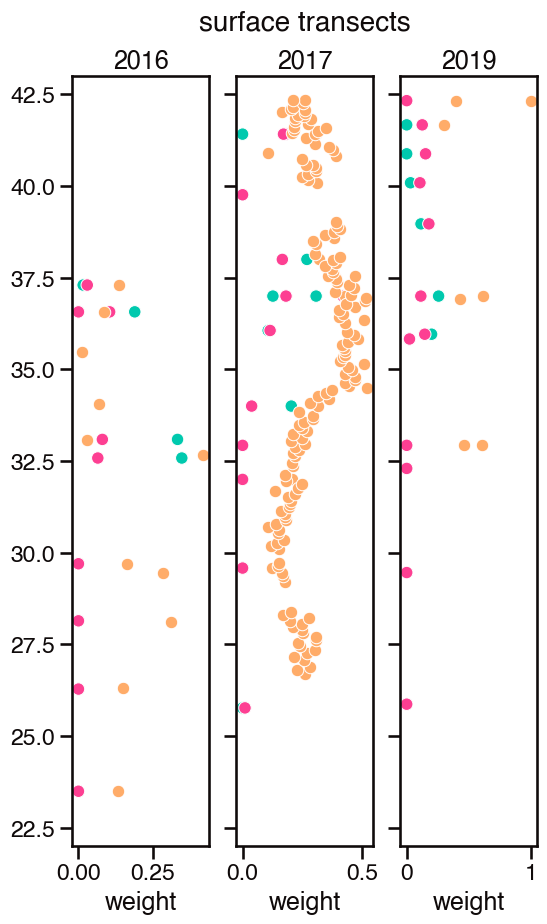

In [72]:
# plot surface transect data

# set up figure
sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
fig = plt.figure(figsize=(6, 10))
rows = 1
cols = 3
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)
n_bins = 21
bounds = (23, 43)

# set up data
fig_df = fe_cluster_df.copy()

# iterate through data
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[0, i])
    if i == 1:
        axis.annotate('surface transects', xy=(.5, 1.07), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data together
    plot_df = fig_df[fig_df['samplegroup'] == 'surface transect']
    plot_df = plot_df[plot_df['year'] == year]
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    plot_df = plot_df.groupby(['genus', 'latitude']).sampleweights.median().reset_index()
    # make figure
    sns.scatterplot(
        data=plot_df, x='sampleweights', y='latitude', hue='genus', palette=[sns.color_palette()[i] for i in [2, 3]], 
        legend=False, ax=axis
    )
    # add iron data
    sns.scatterplot(
        data=fe_df[(fe_df['year'] == year) & (fe_df['depth'].le(15))], 
        x='Fe_dissolved', y='lat', 
        # errorbar='sd', err_style='bars', orient='y', 
        ax=axis, 
        color=sns.color_palette()[1]
    )
    # # add dissolved nitrate and nitrite data
    # sns.scatterplot(
    #     data=n_diss_df[(n_diss_df['year'] == year) & (n_diss_df['depth'].le(15))], 
    #     x='NO3_NO2', y='lat', 
    #     # errorbar='sd', err_style='bars', orient='y', 
    #     ax=axis, 
    #     color=sns.color_palette()[6]
    # )
    # set labels and such
    # axis.set(xlim=sample_weight_range, ylabel='', xlabel='weight', title=year)
    axis.set(ylim=[22, 43], ylabel='', xlabel='weight', title=year)
    if not i:
        continue
        # axis.set_yticks(np.arange(n_bins), [f'{int(l)}N' for l in np.linspace(bounds[1], bounds[0], num=n_bins)])
    else:
        axis.tick_params(left=True, labelleft=False)


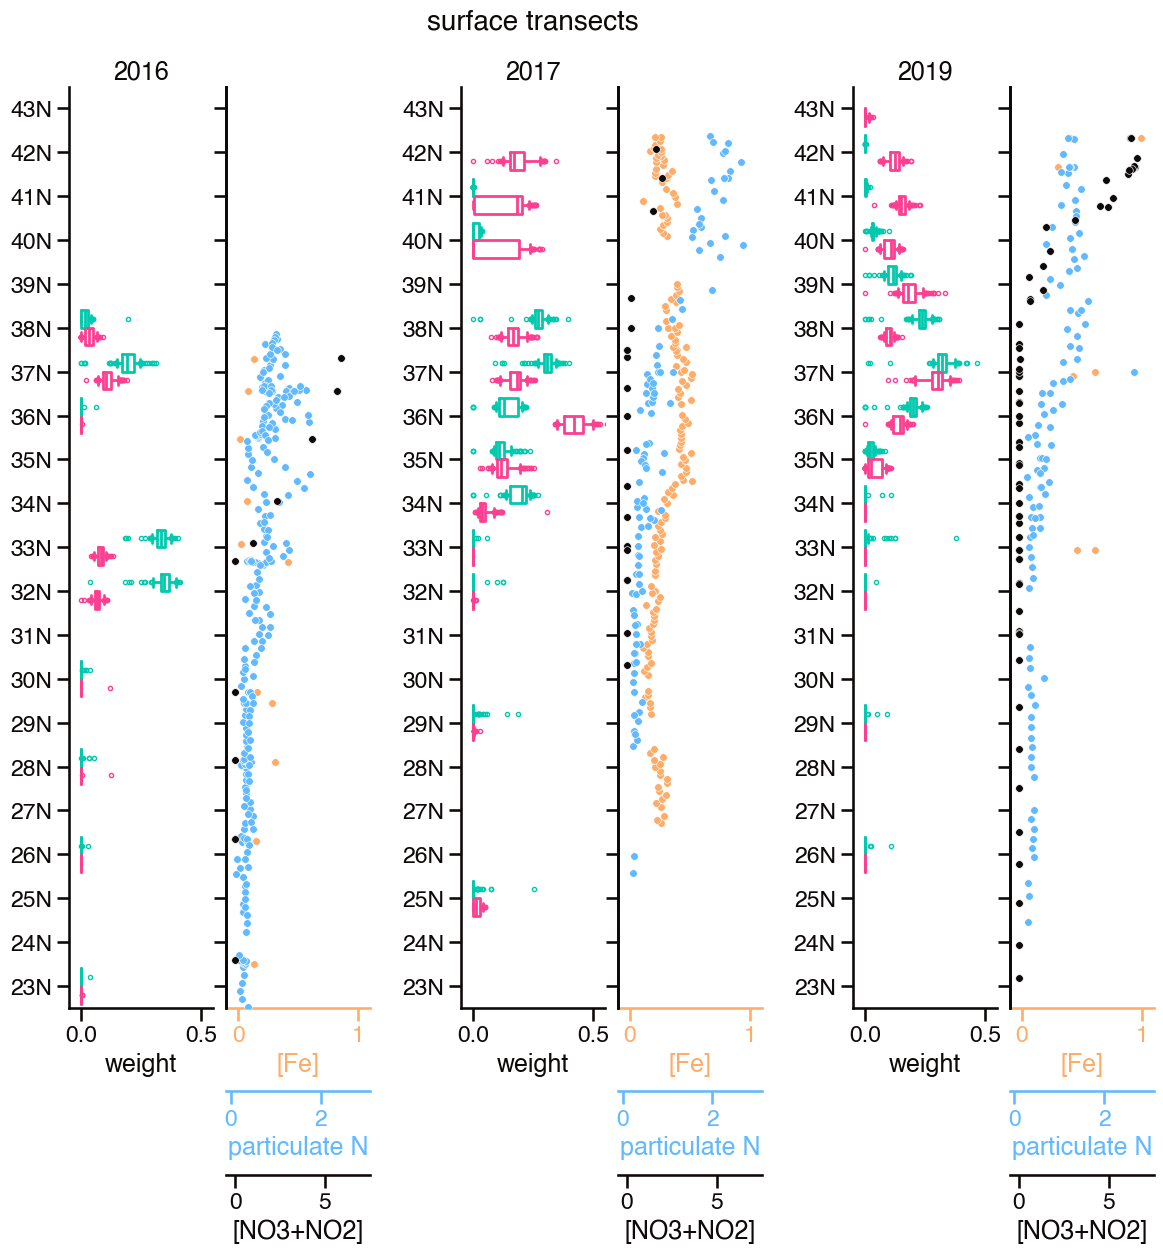

In [179]:
# plot surface transect data

# set up figure
sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
fig = plt.figure(figsize=(15, 15))
rows = 15
cols = 15
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)
n_bins = 21
bounds = (23, 43)

# plot cluster weight data
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[0:12, 5*i:5*i+2])
    if i == 1:
        axis.annotate('surface transects', xy=(.5, 1.07), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data together
    plot_df = fe_cluster_df[fe_cluster_df['samplegroup'] == 'surface transect']
    plot_df = plot_df[plot_df['year'] == year]
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    sns.boxplot(
        data=plot_df, x='sampleweights', y='lat_idx', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
        palette=[sns.color_palette()[i] for i in [2, 3]], 
        orient='h', order=np.arange(n_bins), fill=False, whis=(5, 95), fliersize=3, legend=False, ax=axis
    )
    # set labels and such
    axis.set(xlim=sample_weight_range, ylabel='', xlabel='weight', title=year)
    axis.set_yticks(np.arange(n_bins), [f'{int(l)}N' for l in np.linspace(bounds[1], bounds[0], num=n_bins)])

# plot environmental covariates
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[0:12, 5*i+2:5*i+4])
    # dissolved iron
    color = sns.color_palette()[1]
    sns.scatterplot(
        data=fe_df[(fe_df['year'] == year) & (fe_df['depth'].le(15))], 
        x='Fe_dissolved', y='lat', 
        ax=axis, 
        color=color, 
        s=30
    )
    axis.set(xlim=(-.1, 1.1), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[Fe]', ylabel='')
    axis.tick_params(left=True, labelleft=False)
    axis.tick_params(axis='x', colors=color)
    axis.xaxis.label.set_color(color)
    axis.spines['bottom'].set_color(color)
    # particulate nitrogen
    color = sns.color_palette()[7]
    axis2 = plt.twiny(axis)
    sns.scatterplot(
        data=n_part_df[(n_part_df['year'] == year) & (n_part_df['depth'].le(15))], 
        x='pn', y='lat', 
        ax=axis2, 
        color=color, 
        s=30
    )
    axis2.set(xlim=(-.1, 3.1), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='particulate N', ylabel='')
    axis2.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis2.tick_params(axis='x', colors=color)
    axis2.xaxis.set_label_position('bottom')
    axis2.xaxis.label.set_color(color)
    axis2.spines['bottom'].set_color(color)
    axis2.spines['bottom'].set_position(('outward', 60))
    # dissolved nitrate + nitrite
    color = sns.color_palette()[4]
    axis3 = plt.twiny(axis2)
    sns.scatterplot(
        data=n_diss_df[(n_diss_df['year'] == year) & (n_diss_df['depth'].le(15))], 
        x='NO3_NO2', y='lat', 
        ax=axis3, 
        color=color, 
        s=30
    )
    axis3.set(xlim=(-0.5, 7.5), ylim=(bounds[0]-0.5, bounds[1]+.5), yticks=np.linspace(bounds[0], bounds[1], n_bins), 
             xlabel='[NO3+NO2]', ylabel='')
    axis3.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    axis3.tick_params(axis='x', colors=color)
    axis3.xaxis.set_label_position('bottom')
    axis3.xaxis.label.set_color(color)
    axis3.spines['bottom'].set_color(color)
    axis3.spines['bottom'].set_position(('outward', 120))



In [149]:
sns.color_palette()


[(0.6078431372549019, 0.36470588235294116, 0.8980392156862745),
 (1.0, 0.6745098039215687, 0.4117647058823529),
 (0.0, 0.788235294117647, 0.6823529411764706),
 (0.9921568627450981, 0.24705882352941178, 0.5725490196078431),
 (0.058823529411764705, 0.0392156862745098, 0.0392156862745098),
 (0.5843137254901961, 0.6039215686274509, 0.6941176470588235),
 (1.0, 0.8588235294117647, 0.4),
 (0.38823529411764707, 0.7254901960784313, 1.0),
 (1.0, 0.6941176470588235, 0.792156862745098),
 (0.30980392156862746, 0.11372549019607843, 0.8431372549019608)]

In [ ]:
fig_df[fig_df.year == 2016].groupby(['genus', 'year', 'samplename', 'datetime', 'latitude']).sampleweights.mean()

In [ ]:
fig = plt.figure(figsize=(16, 20))
rows = 12
cols = 9
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}